## Imports

In [38]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-4rd9w1lz
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-4rd9w1lz
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit 22d84a7180f299da877490cf79104f57b343f1af
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [39]:
!pip install lightning

In [40]:
import os
import h5py
import torch
import numpy as np
import pandas as pd
import lightning as L
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from torch.optim import lr_scheduler
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

In [41]:
print(torch.cuda.is_available())
print(torch.version.cuda)

True
12.4


# Loading data
The dataset used for this training is from [Landslide4Sense](https://github.com/iarai/Landslide4Sense-2022) competition. It is a set of:
 - train images + segmentation masks
 - validation images + segmentation masks
 - test images + segmentation masks

In [42]:
DATA_DIR = "/kaggle/input/landslide4sense-2022/Landslide4Sense_2022/"

x_test_dir = os.path.join(DATA_DIR, "test", "img")
y_test_dir = os.path.join(DATA_DIR, "test", "mask")

## Dataloader
Writing helper class for data extraction, tranformation and preprocessing
https://pytorch.org/docs/stable/data

In [43]:
class Landslide4SenseDataset(BaseDataset):
    """
    Dataset class for binary segmentation of landslide-affected areas using multidimensional geospatial data.

    Args:
        images_dir (str): Path to the folder containing input HDF5 image files.
        masks_dir (str): Path to the folder containing corresponding HDF5 binary mask files (0 = background, 255 = landslide area).
    """

    def __init__(self, images_dir, masks_dir):
        # Get list of all file IDs from the images directory
        self.ids = os.listdir(images_dir)
        
        # Construct full paths for images and masks
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        # Precomputed mean and std for each of the 14 image channels (for normalization)
        self.mean = [-0.4914, -0.3074, -0.1277, -0.0625, 0.0439, 0.0803, 0.0644, 0.0802, 0.3000, 0.4082, 0.0823, 0.0516, 0.3338, 0.7819]
        self.std =  [0.9325, 0.8775, 0.8860, 0.8869, 0.8857, 0.8418, 0.8354, 0.8491, 0.9061, 1.6072, 0.8848, 0.9232, 0.9018, 1.2913]

    def __getitem__(self, i):
        """
        Load and return one image-mask pair with preprocessing.

        Returns:
            image (np.ndarray): Normalized input image with shape (C, H, W).
            label (np.ndarray): Binary mask with shape (1, H, W).
        """

        # Load image data from HDF5 file
        with h5py.File(self.images_fps[i], 'r') as hf:
            image = hf['img'][:]

        # Load corresponding mask data from HDF5 file
        with h5py.File(self.masks_fps[i], 'r') as hf:
            label = hf['mask'][:]

        # Convert image and label to float32 numpy arrays
        image = np.asarray(image, np.float32)
        label = np.asarray(label, np.float32)

        # Rearrange image dimensions from (H, W, C) to (C, H, W) for PyTorch
        image = image.transpose((-1, 0, 1))

        # Add channel dimension to label to make shape (1, H, W)
        label = np.expand_dims(label, axis=0)

        # Normalize each channel of the image using precomputed mean and std
        for i in range(len(self.mean)):
            image[i, :, :] -= self.mean[i]
            image[i, :, :] /= self.std[i]

        return image.copy(), label.copy()

    def __len__(self):
        """
        Return the number of samples in the dataset.
        """
        return len(self.ids)

In [44]:
dataset = Landslide4SenseDataset(x_train_dir, y_train_dir)

In [46]:
test_dataset = Landslide4SenseDataset(x_test_dir, y_test_dir)

print(f"Test dataset size: {len(test_dataset)}")

Test dataset size: 800


In [47]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [48]:
def normalize_channel(channel):
    ch = channel.copy()
    ch = ch - ch.min()
    ch = ch / (ch.max() + 1e-6)
    return ch

def show_multiple_samples(dataset, indices=[0, 1, 2, 3, 4]):
    num_samples = len(indices)
    num_bands = 13  # 12 bands + RGB + mask

    fig, axes = plt.subplots(num_samples, num_bands, figsize=(num_bands * 3, num_samples * 3))
    if num_samples == 1:
        axes = np.expand_dims(axes, axis=0)  # ensure 2D shape

    for row, idx in enumerate(indices):
        image, mask = dataset[idx]
        mask = mask.squeeze()

        # Extract and normalize channels
        aerosol = normalize_channel(image[0])         # B1
        blue = normalize_channel(image[1])            # B2
        green = normalize_channel(image[2])           # B3
        red = normalize_channel(image[3])             # B4
        rgb = np.stack([red, green, blue], axis=-1)   # RGB Composite

        re1 = normalize_channel(image[4])             # B5
        re2 = normalize_channel(image[5])             # B6
        re3 = normalize_channel(image[6])             # B7
        nir = normalize_channel(image[7])             # B8
        water_vapour = normalize_channel(image[8])    # B9
        cirrus = normalize_channel(image[9])          # B10
        swir1 = normalize_channel(image[10])          # B11
        swir2 = normalize_channel(image[11])          # B12
        slope = normalize_channel(image[12])          # B13
        dem = normalize_channel(image[13])            # B14

        # List of (title, image, colormap)
        channels = [
            ("RGB (B4,B3,B2)", rgb, None),
            ("Aerosol (B1)", aerosol, 'Blues'),
            ("RE1 (B5)", re1, 'Greens'),
            ("RE2 (B6)", re2, 'YlGn'),
            ("RE3 (B7)", re3, 'YlGnBu'),
            ("NIR (B8)", nir, 'inferno'),
            ("WV (B9)", water_vapour, 'PuBu'),
            ("Cirrus (B10)", cirrus, 'bone'),
            ("SWIR1 (B11)", swir1, 'magma'),
            ("SWIR2 (B12)", swir2, 'magma'),
            ("Slope (B13)", slope, None),
            ("DEM (B14)", dem, None),
            ("Mask", mask, 'gray')
        ]

        # Plot each band
        for col, (title, img, cmap) in enumerate(channels):
            ax = axes[row, col]
            if title == "RGB (B4,B3,B2)":
                ax.imshow(img)
            else:
                ax.imshow(img, cmap=cmap)
            if row == 0:
                ax.set_title(title, fontsize=14)
            ax.axis('off')

    plt.tight_layout(pad=2)
    plt.savefig("landslide4sense_samples.png")
    plt.show()


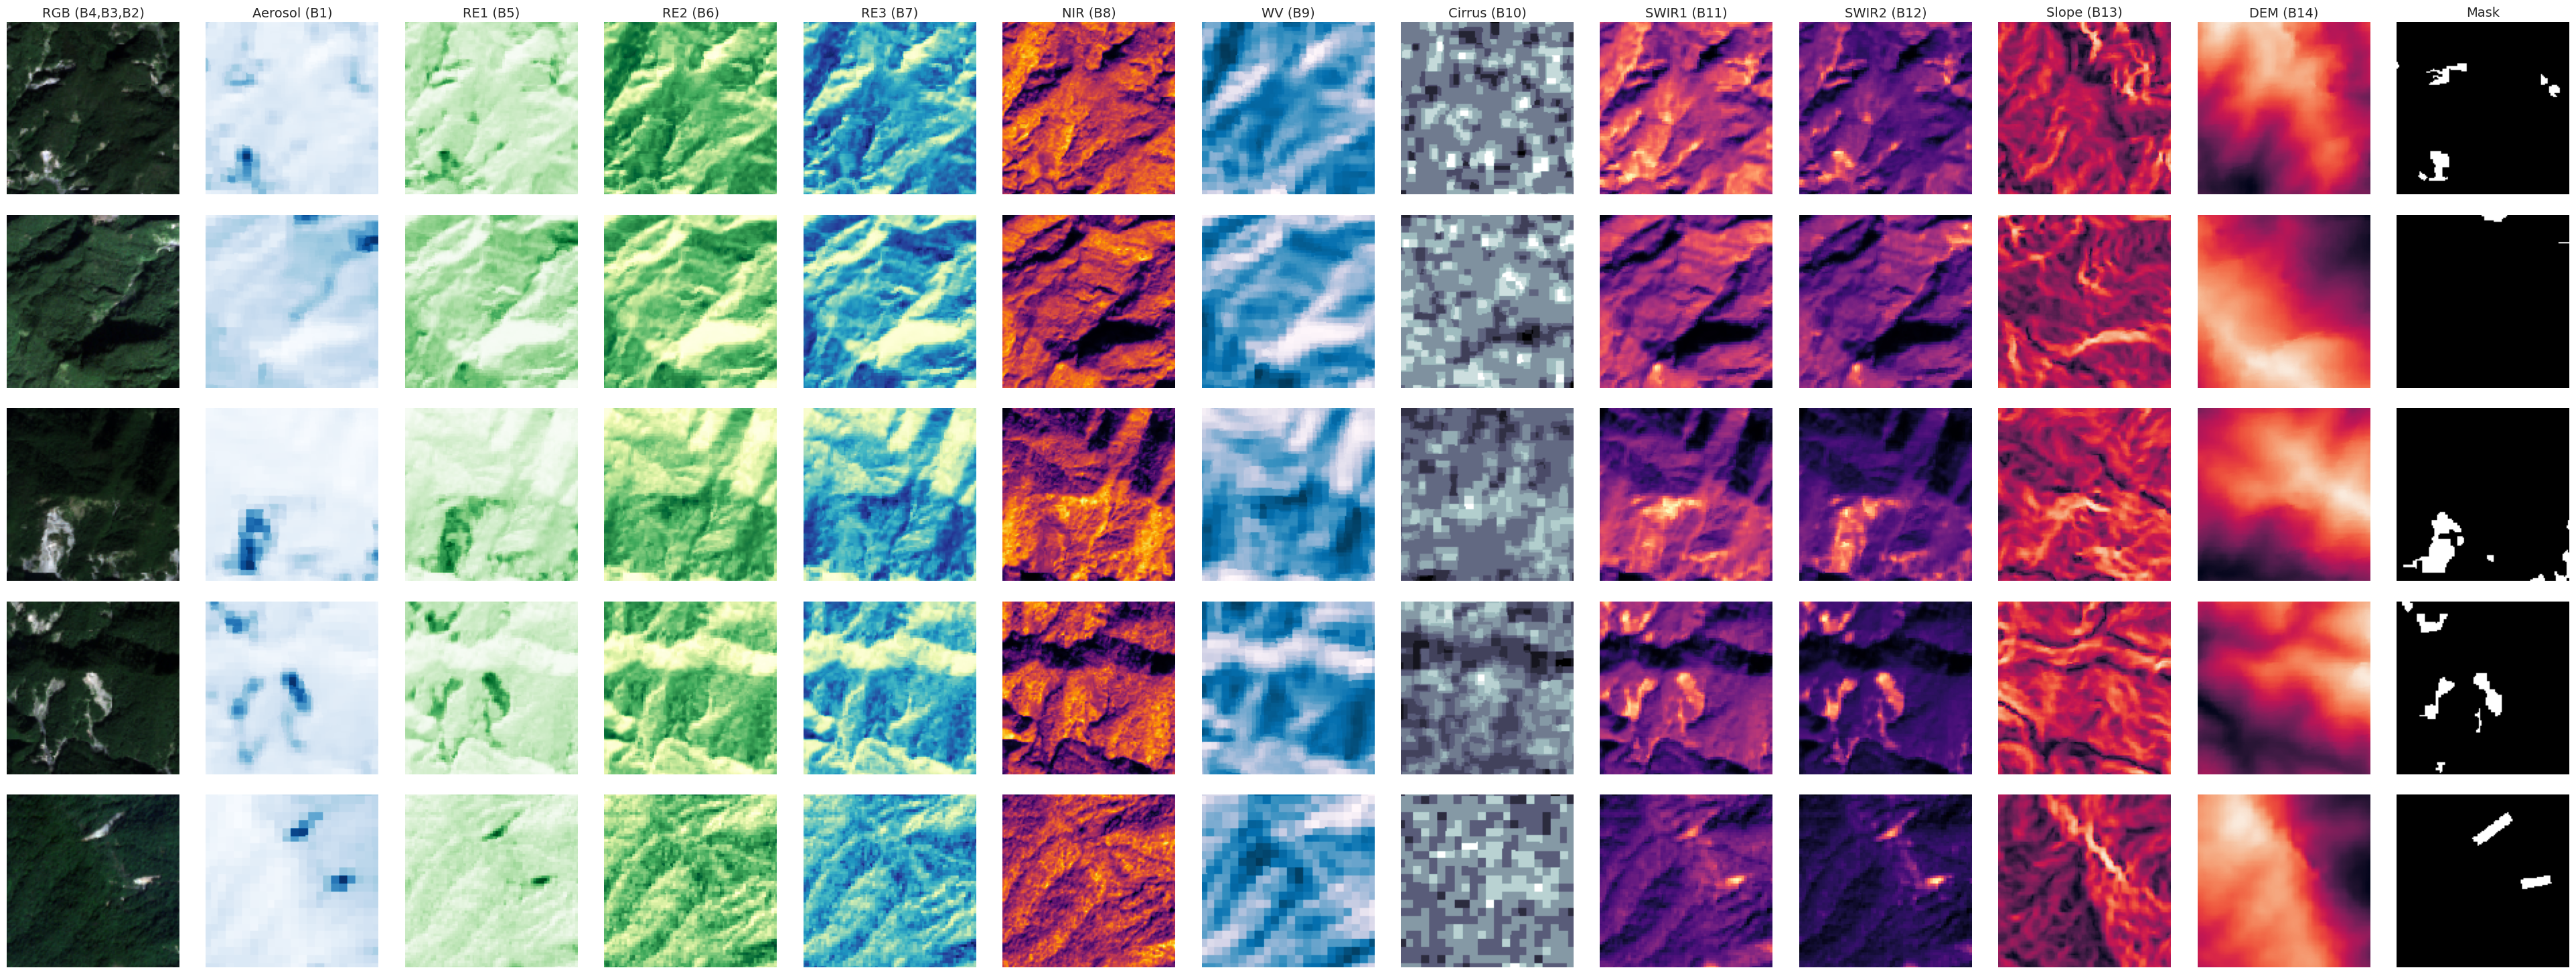

In [49]:
show_multiple_samples(test_dataset, indices=[4, 30, 80, 13, 24])

## Loading Trained Model

In [50]:
# load the model
restored_model = smp.from_pretrained("saved-model-dir/deeplabv1/")
print(restored_model)

Loading weights from local directory
DeepLabV3(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(14, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=Tru

## Evaluation

In [64]:
from tqdm import tqdm
all_tp, all_fp, all_fn, all_tn = [], [], [], []

device = "cpu"

# Turn off gradient computation for evaluation
with torch.no_grad():
    for images, masks in tqdm(test_loader):
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        logits = restored_model(images)
        probs = logits.sigmoid()
        preds = (probs > 0.5).float()

        # Compute stats
        tp, fp, fn, tn = smp.metrics.get_stats(preds.long(), masks.long(), mode="binary")
        all_tp.append(tp)
        all_fp.append(fp)
        all_fn.append(fn)
        all_tn.append(tn)

# Aggregate stats
tp = torch.cat(all_tp)
fp = torch.cat(all_fp)
fn = torch.cat(all_fn)
tn = torch.cat(all_tn)

# Compute final metrics
iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
f1 = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro")
precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro")

print("Validation Metrics:")
print(f"IoU:       {iou.item():.4f}")
print(f"F1 Score:  {f1.item():.4f}")
print(f"Recall:    {recall.item():.4f}")
print(f"Precision: {precision.item():.4f}")

100%|██████████| 25/25 [03:12<00:00,  7.72s/it]

Validation Metrics:
IoU:       0.3913
F1 Score:  0.5625
Recall:    0.5831
Precision: 0.5433


## Result Visualization

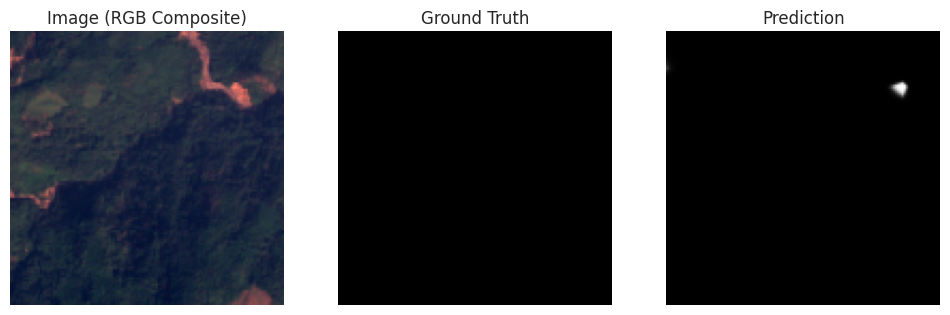

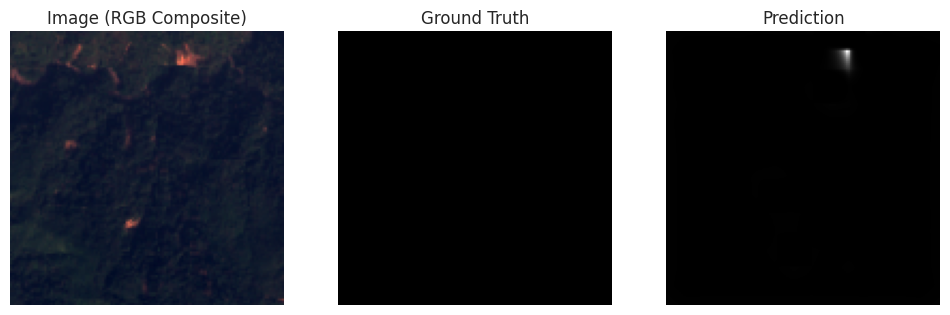

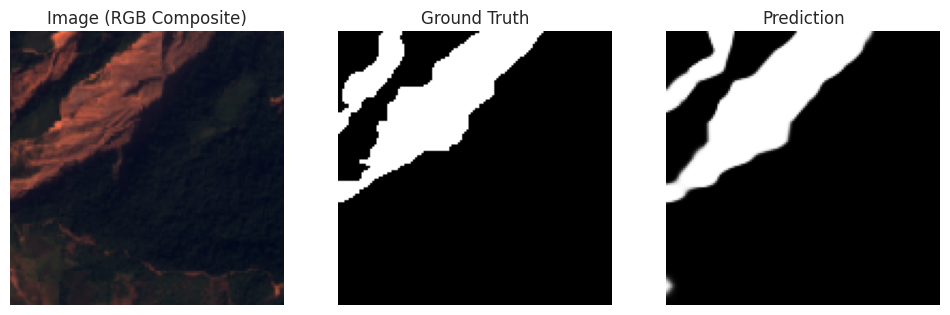

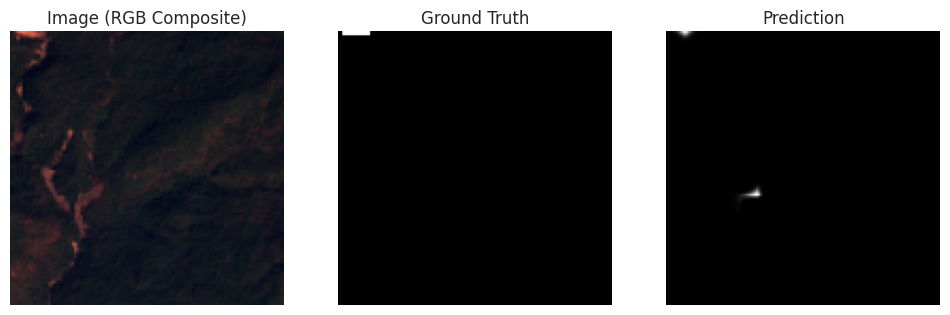

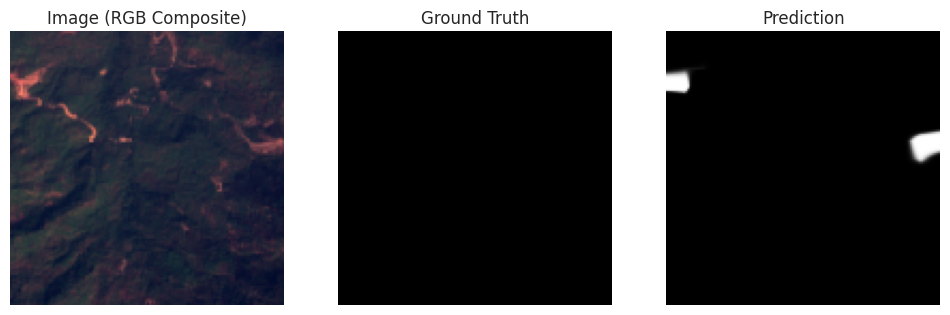

In [65]:
images, masks = next(iter(test_loader))
with torch.inference_mode():
    restored_model.eval()
    logits = restored_model(images)
pr_masks = logits.sigmoid()

for idx, (image, gt_mask, pr_mask) in enumerate(zip(images, masks, pr_masks)):
    if idx <= 4:
        # Create RGB composite from bands: B4 (Red), B3 (Green), B2 (Blue)
        rgb = image[[3, 2, 1], :, :]  # (3, 128, 128)
        
        # Normalize RGB for visualization (min-max normalization)
        rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(rgb.permute(1, 2, 0).numpy())
        plt.title("Image (RGB Composite)")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.squeeze().numpy(), cmap='gray')
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.squeeze().numpy(), cmap='gray')
        plt.title("Prediction")
        plt.axis("off")

        plt.show()
    else:
        break

## Changing to ONNX

In [62]:
# to make onnx export work
!pip install onnx onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 93.2 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.7 MB/s eta 0:00:00


In [63]:
import onnx
import onnxruntime

In [66]:
# dynamic_axes is used to specify the variable length axes. it can be just batch size
dynamic_axes = {0: "batch_size", 2: "height", 3: "width"}

onnx_model_name = "landslide3sense_deeplabv1.onnx"

onnx_model = torch.onnx.export(
    restored_model,  # model being run
    torch.randn(1, 14, 128, 128),  # model input
    onnx_model_name,  # where to save the model (can be a file or file-like object)
    export_params=True,  # store the trained parameter weights inside the model file
    opset_version=17,  # the ONNX version to export
    do_constant_folding=True,  # whether to execute constant folding for optimization
    input_names=["input"],  # the model's input names
    output_names=["output"],  # the model's output names
    dynamic_axes={  # variable length axes
        "input": dynamic_axes,
        "output": dynamic_axes,
    },
)

In [67]:
# check with onnx first
onnx_model = onnx.load(onnx_model_name)
onnx.checker.check_model(onnx_model)

## Run with ONNXRuntime

In [68]:
# create sample with different batch size, height and width
# from what we used in export above
sample = torch.randn(2, 14, 128, 128)

ort_session = onnxruntime.InferenceSession(
    onnx_model_name, providers=["CPUExecutionProvider"]
)

# compute ONNX Runtime output prediction
ort_inputs = {"input": sample.numpy()}
ort_outputs = ort_session.run(output_names=None, input_feed=ort_inputs)
ort_outputs

[array([[[[-5.268518 , -5.360474 , -5.4524302, ..., -5.52825  ,
           -5.412209 , -5.2961664],
          [-5.379273 , -5.4821267, -5.58498  , ..., -5.692278 ,
           -5.5721316, -5.4519844],
          [-5.4900274, -5.6037784, -5.71753  , ..., -5.856306 ,
           -5.7320547, -5.6078033],
          ...,
          [-5.266309 , -5.4343257, -5.602342 , ..., -6.0147243,
           -5.881764 , -5.7488027],
          [-5.0679936, -5.2317424, -5.3954906, ..., -5.861023 ,
           -5.7374177, -5.613811 ],
          [-4.869677 , -5.0291576, -5.188638 , ..., -5.70732  ,
           -5.5930696, -5.478819 ]]],
 
 
        [[[-5.169567 , -5.2682924, -5.367018 , ..., -5.3938713,
           -5.2238545, -5.0538363],
          [-5.291072 , -5.402923 , -5.514774 , ..., -5.603778 ,
           -5.4398737, -5.275969 ],
          [-5.4125776, -5.5375543, -5.66253  , ..., -5.8136835,
           -5.6558933, -5.4981017],
          ...,
          [-5.463269 , -5.614999 , -5.7667284, ..., -5.932253 ,


## Verify it's the same as for pytorch model

In [69]:
# compute PyTorch output prediction
with torch.inference_mode():
    torch_out = restored_model(sample)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(torch_out.numpy(), ort_outputs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

Exported model has been tested with ONNXRuntime, and the result looks good!
